<a href="https://colab.research.google.com/github/i-ganza007/-Time-Series-Forecasting/blob/main/_TimeSeries19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [59]:
# from google.colab import drive
# drive.mount('/content/drive')


In [60]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')


In [61]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [62]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [63]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


In [64]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


In [65]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [66]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

In [73]:
# define model
model = Sequential([
    LSTM(256, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.5),
    LSTM(128, activation="relu", return_sequences=True),
    Dropout(0.4),
    LSTM(64, activation="tanh"),
    Dense(32, activation="relu"),
    Dense(1)
])

# Define the RMSprop optimizer
adx_optimizer=tf.keras.optimizers.Adam(0.0003)
model.compile(
    optimizer=adx_optimizer,
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 1, 256)         │       272,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 521,025 (1.99 MB)

 Trainable params: 521,025 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=16
)

Epoch 1/25
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 76s 14ms/step - lambda: 100.5942 - loss: 11376.8135
Epoch 2/25
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - lambda: 71.2641 - loss: 5669.5293
Epoch 3/25
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - lambda: 71.2501 - loss: 5647.5566
Epoch 4/25
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - lambda: 71.3322 - loss: 5596.2544
Epoch 5/25
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - lambda: 69.8028 - loss: 5433.2007
Epoch 6/25
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - lambda: 69.6841 - loss: 5449.1392
Epoch 7/25
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - lambda: 70.5188 - loss: 5518.3359
Epoch 8/25
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - lambda: 69.6877 - loss: 5363.2261
Epoch 9/25
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - lambda: 69.7185 - loss: 5355.4297
Epoch 10/25
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - lambda: 68.8858 - loss: 5201.0288
Epoch 11/25
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - lambda: 69.5280 - 

959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


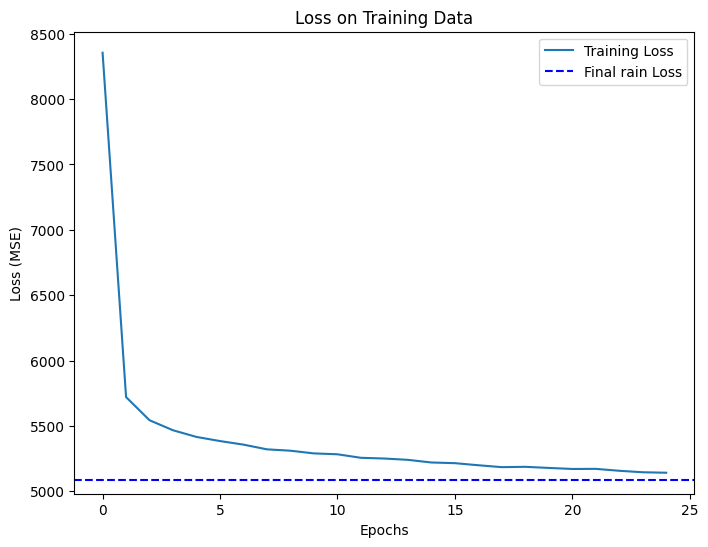

Final Training Loss (MSE): 5086.69012761302


In [75]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [76]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('#timeseries19.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
